**Import Statements**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

**data preprocessing**

In [2]:
df_01 = pd.read_csv('../data/Bengaluru_House_Data.csv')
df_01.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


* dropping features not required by the model

In [3]:
df_02 = df_01.drop(['area_type','society','balcony','availability'], axis='columns')
df_02.shape

(13320, 5)

In [4]:
df_02.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [5]:
df_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    13319 non-null  object 
 1   size        13304 non-null  object 
 2   total_sqft  13320 non-null  object 
 3   bath        13247 non-null  float64
 4   price       13320 non-null  float64
dtypes: float64(2), object(3)
memory usage: 520.4+ KB


* checking for null values and dealing with them

In [6]:
df_02.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
df_03 = df_02.dropna()
df_03.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

**Exploring size feature**

In [8]:
df_03['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

* creating new feature bhk that only keeps the numerical value of size

In [9]:
df_03['bhk'] = df_03['size'].apply(lambda x:int(x.split(' ')[0]))

C:\Users\Shubh\AppData\Local\Temp\ipykernel_17316\79494514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_03['bhk'] = df_03['size'].apply(lambda x:int(x.split(' ')[0]))


In [10]:
df_03.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


* removing the redundant size feature

In [11]:
df_04 = df_03.drop(['size'], axis='columns')
df_04.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


**Exploring total_sqft feature**

* Checks if the value is float or not

In [12]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [13]:
df_04[~df_04["total_sqft"].apply(is_float)].head(10)

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
410,Kengeri,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,63.770,2
648,Arekere,4125Perch,9.0,265.000,9
661,Yelahanka,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,3090 - 5002,4.0,445.000,4


* convering the total_sqft in ranges into float values by taking the average of maximum and minimum value of the range
* dropping other cases outlier cases for simplicity

In [14]:
def convert_sqft_to_number(x):
    tokens = x.split("-")
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [15]:
df_04["total_sqft"] = df_04["total_sqft"].apply(convert_sqft_to_number)

In [16]:
df_04.isnull().sum()

location       0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

In [17]:
df_05 = df_04.dropna()
df_05.shape

(13200, 5)

In [18]:
df_05.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2


* Feature engineering - adding a new feature price per sq feet

In [19]:
df_06 = df_05.copy()
df_06['price_per_sqft'] = df_06["price"]*100000/df_06["total_sqft"]
df_06.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


**Exploring location feature**

In [20]:
df_06['location'].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], dtype=object)

* number of unique locations

In [21]:
len(df_06.location.unique())

1298

In [22]:
df_06.location = df_06.location.apply(lambda x: x.strip())
df_06.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


* checking the highest 20 values

In [23]:
location_stats = df_06['location'].value_counts(ascending=False)
location_stats.head(20)

location
Whitefield                  533
Sarjapur  Road              392
Electronic City             304
Kanakpura Road              264
Thanisandra                 235
Yelahanka                   210
Uttarahalli                 186
Hebbal                      176
Marathahalli                175
Raja Rajeshwari Nagar       171
Bannerghatta Road           151
Hennur Road                 150
7th Phase JP Nagar          148
Haralur Road                141
Electronic City Phase II    131
Rajaji Nagar                106
Chandapura                   98
Bellandur                    96
Hoodi                        88
KR Puram                     88
Name: count, dtype: int64

* checking the lowest 20 values

In [24]:
location_stats.tail(20)

location
Hullahalli                        1
Gangondanahalli                   1
Shettihalli                       1
MRCR Layout                       1
Arekempanahalli                   1
Sonam Layout                      1
1 Ramamurthy Nagar                1
Fraser town                       1
NTI Layout                        1
2Electronic City Phase II         1
1A Block Koramangala              1
asha township, off hennur road    1
Escorts Colony                    1
Rahat Bagh                        1
Nagarbhavi  BDA Complex           1
Rajanna Layout                    1
Subramanyanagar                   1
Lakshmipura Vidyaanyapura         1
Malur Hosur Road                  1
Abshot Layout                     1
Name: count, dtype: int64

In [25]:
len(location_stats[location_stats<=10])

1047

In [26]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
BTM 1st Stage                10
Gunjur Palya                 10
Nagappa Reddy Layout         10
Sector 1 HSR Layout          10
Thyagaraja Nagar             10
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: count, Length: 1047, dtype: int64

* changing the value of all locations whose count is less than 10 to 'other' 
* this reduces the dimensionality of the data

In [27]:
df_07 = df_06.copy()
df_07.location = df_07.location.apply(lambda x: 'Other' if x in location_stats_less_than_10 else x)
len(df_07.location.unique())

241

In [28]:
df_07.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


**Outlier Removal**

* Discarding outliers by keeping minimum sqft per bhk as 300

In [29]:
df_07[df_07.total_sqft/df_07.bhk<300].head()

,location,total_sqft,bath,price,bhk,price_per_sqft
9,Other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
70,Other,500.0,3.0,100.0,3,20000.000000


In [30]:
df_08 = df_07[~(df_07.total_sqft/df_07.bhk<300)]
df_08.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


* outlier removal using the mean and std deviation of price per sq ft by location

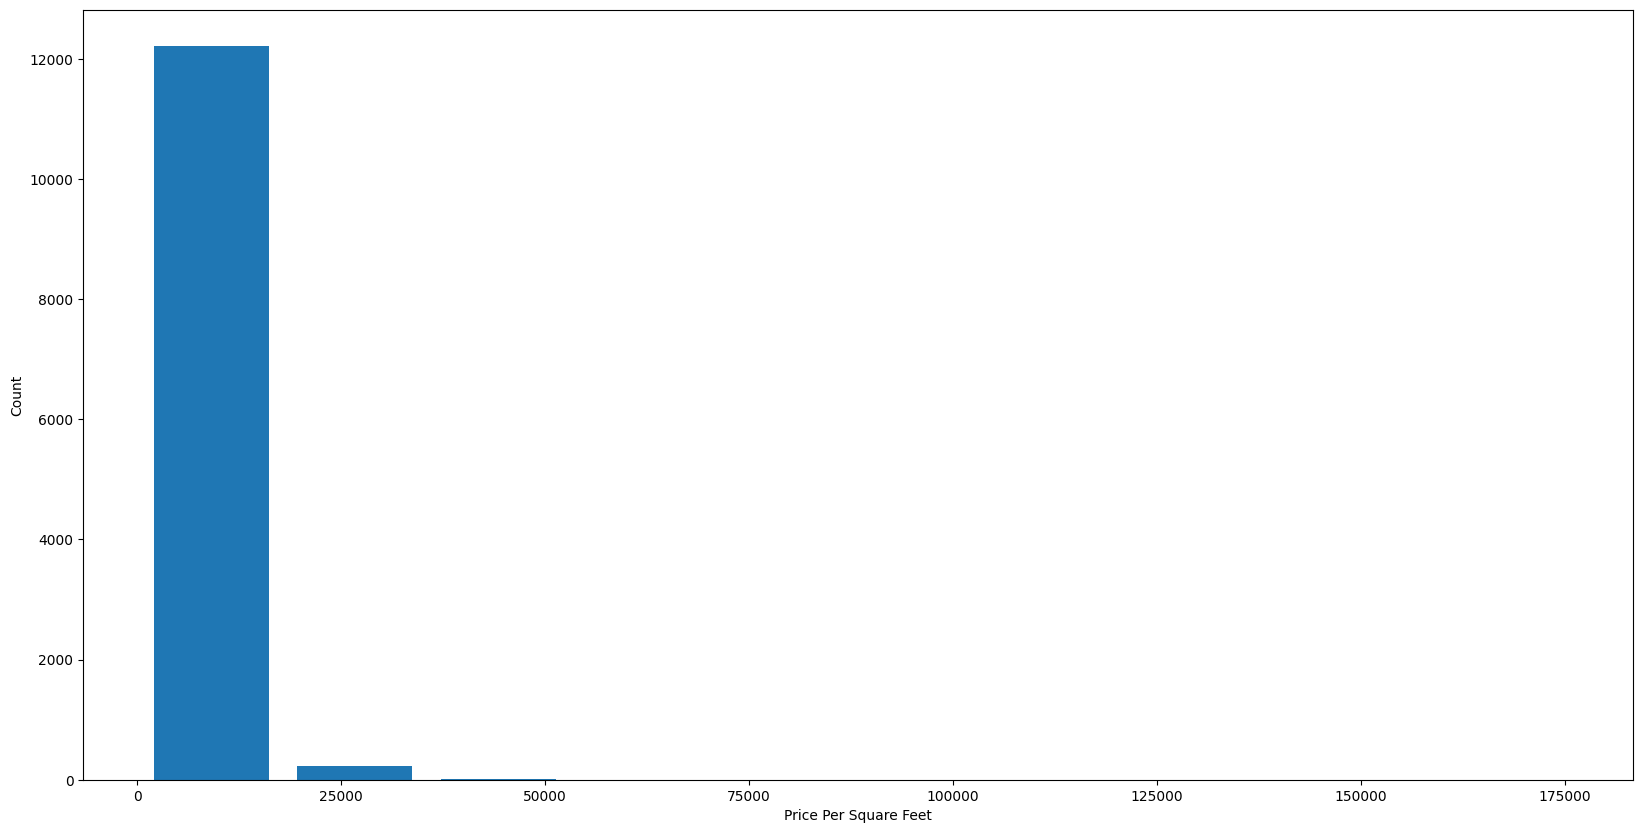

In [31]:
plt.hist(df_08.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

In [32]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out

In [33]:
df_09 = remove_pps_outliers(df_08)
df_09.shape

(10242, 6)

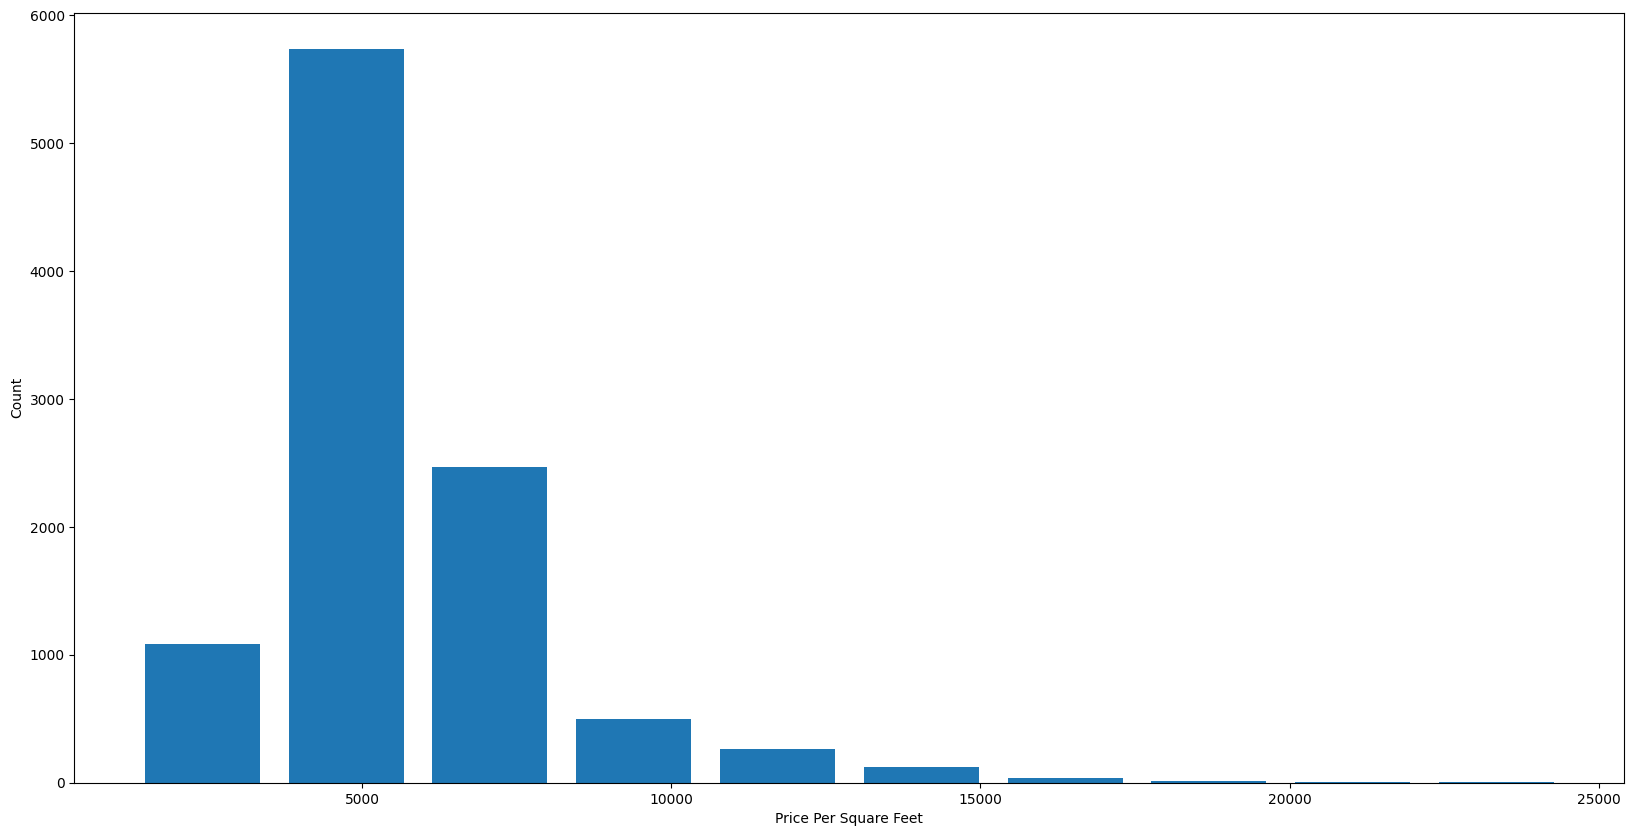

In [34]:
plt.hist(df_09.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")
plt.show()

* removing outliers by discarding data where bathrooms are 2 more than bedrooms

In [35]:
df_09[df_09.bath>df_09.bhk+2]

,location,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,7000.0,8.0,450.0,4,6428.571429
5851,Other,11338.0,9.0,1000.0,6,8819.897689
9017,Thanisandra,1806.0,6.0,116.0,3,6423.034330


In [36]:
df_10 = df_09[~(df_09.bath>df_09.bhk+2)]

In [37]:
df_10.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,1235.0,2.0,148.0,2,11983.805668


**Addressing catagorical data**

* Saving unique locations in a file to be accessed later

In [38]:
import json

In [39]:
unique_locations = df_10['location'].unique()

with open('../data/unique_locations.json', 'w') as f:
    json.dump(list(unique_locations), f)

* one hot encoding to deal with the categorical data

In [40]:
dummies = pd.get_dummies(df_10['location']).astype(int)
dummies.head(10)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_11 = pd.concat([df_10, dummies.drop(['Other'], axis='columns')], axis='columns')
df_11.head()

,location,total_sqft,bath,price,bhk,price_per_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.543860,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.840491,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,12533.333333,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,10833.333333,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,11983.805668,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Removing the redundant location colummn

In [42]:
df_11 = df_11.drop('location', axis='columns')
df_11.head()

,total_sqft,bath,price,bhk,price_per_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,15017.543860,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,11901.840491,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,12533.333333,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,10833.333333,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,11983.805668,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Saving the clean data**

In [43]:
df_11.to_csv('../data/clean_data.csv', index=False)